In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from collections import defaultdict
from ringer.utils import significant_around, get_number_order
from ringer.data import load_var_infos
from ringer.latex import confidence_region_df_as_latex, mean_rms_confidence_region
DATASET_TYPES = ["train", "test"]

In [2]:
output_dir = os.path.join("output", "wasserstein_analysis")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

ratios = {
    # 'ratio1': lambda x: x['boosted_el']/x['boosted_jet'],
    'ratio1': lambda x: x['boosted_el']/x['el_jet'],
    'ratio2': lambda x: (x['boosted_jet']-x['boosted_el'])/x['el_jet'],
    'ratio3': lambda x: x['boosted_jet']-x['boosted_el']
}
metric_labels = {
    'ratio1': '$rd_1$',
    'ratio2': '$rd_2$',
    'ratio3': '$rd_3$',
    "boosted_el": "Wasserstein(boosted, el)",
    "boosted_jet": "Wasserstein(boosted, jet)",
    "el_jet": "Wasserstein(el, jet)"
}
n_folds = 10
var_infos = load_var_infos()
var_infos

,name,label,type,formula,description
col,,,,,
trig_L2_cl_et,et,$E_T$,var,NaN,Transverse particle energy on the calorimeter ...
el_et,et,$E_T$,var,NaN,Transverse particle energy on the calorimeter ...
trig_L2_cl_eta,eta,$\eta$,var,NaN,Pseudorapidity (L2Calo stage)
el_eta,eta,$\eta$,var,NaN,Pseudorapidity (Offline stage)
trig_L2_cl_reta,reta,$R_{\eta}$,shower_shape,$R_{\eta} = \frac{E^{3x7}_{EM2}}{E^{7x7}_{EM2}}$,Ratio of the energy in 3x7 cells over the ener...
trig_L2_cl_eratio,eratio,$E_{ratio}$,shower_shape,$E_{ratio} = \frac{E^{max}_{EM1} - E^{2^{nd}ma...,Ratio of the energy difference between the max...
trig_L2_cl_f1,f1,$f_1$,shower_shape,$f_1 = \frac{E^{total}_{EM1}}{E^{total}_{EM}}$,Ratio of the energy in the first layer to the ...
trig_L2_cl_ehad1,ehad1,$E_{had1}$,unidentified,NaN,Unidentified (L2Calo Stage)
trig_L2_cl_f3,f3,$f_3$,shower_shape,$f_3 = \frac{E^{total}_{EM3}}{E^{total}_{EM}}$,Ratio of the energy in the third layer to the ...


In [3]:
wass_distances = pd.read_csv(os.path.join('..', '..', 'data', 'wass_distances.csv'), index_col=0)
for name, func in ratios.items():
    wass_distances[name] = wass_distances.apply(func, axis=1)
wass_distances.rename(dict(index="var"), axis="columns", inplace=True)
wass_distances["var"] = wass_distances["var"].astype("category")
splitted_folds = wass_distances["description"].str.split("_")
wass_distances["fold_type"] = splitted_folds.apply(lambda x: x[-1])
wass_distances["fold_n"] = splitted_folds.apply(lambda x: int(x[1]))
# wass_distances = wass_distances.drop("description", axis="columns")
wass_distances.head(10)

,var,boosted_el,boosted_jet,el_jet,description,ratio1,ratio2,ratio3,fold_type,fold_n
0,trig_L2_cl_reta,0.003692,0.034417,0.031252,fold_0_train,0.118144,0.983138,0.030725,train,0
1,trig_L2_cl_reta,0.003664,0.034350,0.031288,fold_0_test,0.117108,0.980774,0.030686,test,0
2,trig_L2_cl_reta,0.003693,0.034409,0.031257,fold_1_train,0.118137,0.982702,0.030717,train,1
3,trig_L2_cl_reta,0.003683,0.034420,0.031238,fold_1_test,0.117900,0.983982,0.030737,test,1
4,trig_L2_cl_reta,0.003697,0.034414,0.031256,fold_2_train,0.118288,0.982731,0.030716,train,2
5,trig_L2_cl_reta,0.003643,0.034379,0.031249,fold_2_test,0.116577,0.983604,0.030736,test,2
6,trig_L2_cl_reta,0.007819,0.073079,0.066388,fold_3_train,0.117782,0.982998,0.065259,train,3
7,trig_L2_cl_reta,0.007992,0.073187,0.066392,fold_3_test,0.120376,0.981972,0.065195,test,3
8,trig_L2_cl_reta,0.003688,0.034408,0.031256,fold_4_train,0.117989,0.982864,0.030720,train,4
9,trig_L2_cl_reta,0.003702,0.034427,0.031249,fold_4_test,0.118480,0.983197,0.030724,test,4


Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test


/tmp/ipykernel_2979205/2447815389.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio2 train
Plotting ratio2 sub ax train
Plotting ratio2 test
Plotting ratio2 sub ax test
Plotting ratio2 train
Plotting ratio2 sub ax train
Plotting ratio2 test
Plotting ratio2 sub ax test
Plotting ratio2 train
Plotting ratio2 sub ax train
Plotting ratio2 test
Plotting ratio2 sub ax test
Plotting ratio2 train
Plotting ratio2 sub ax train
Plotting ratio2 test
Plotting ratio2 sub ax test


/tmp/ipykernel_2979205/2447815389.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plots[metric_name] = plt.subplots()


Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting ratio3 train
Plotting ratio3 test
Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_el train
Plottin

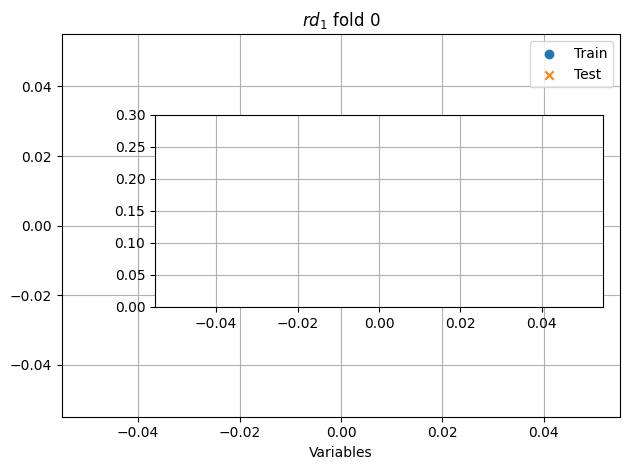

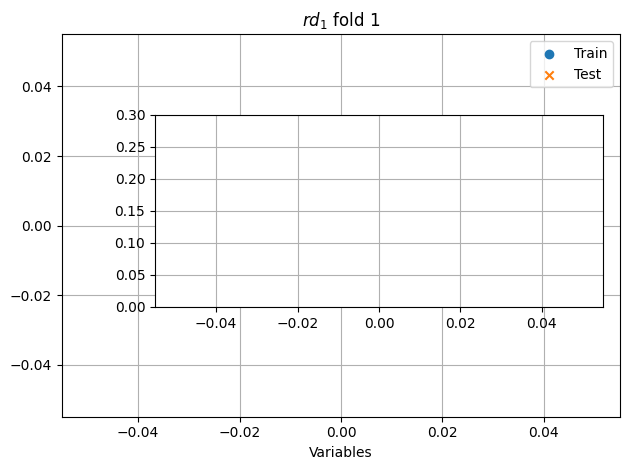

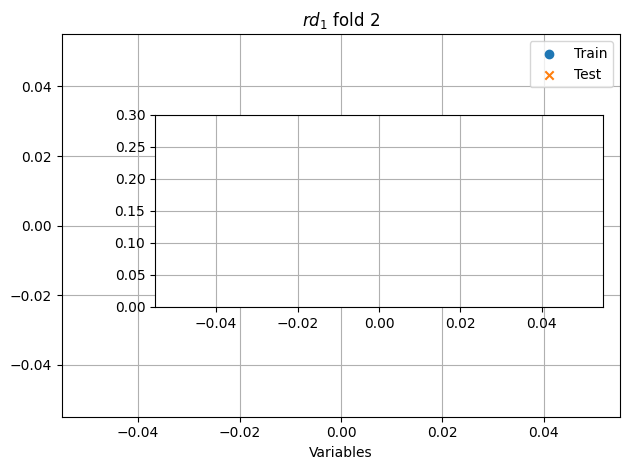

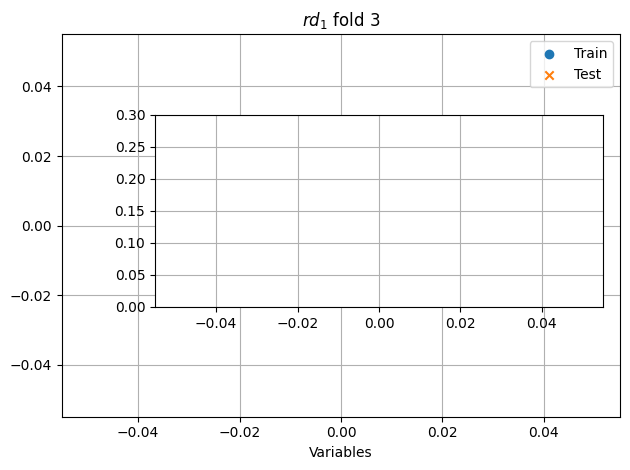

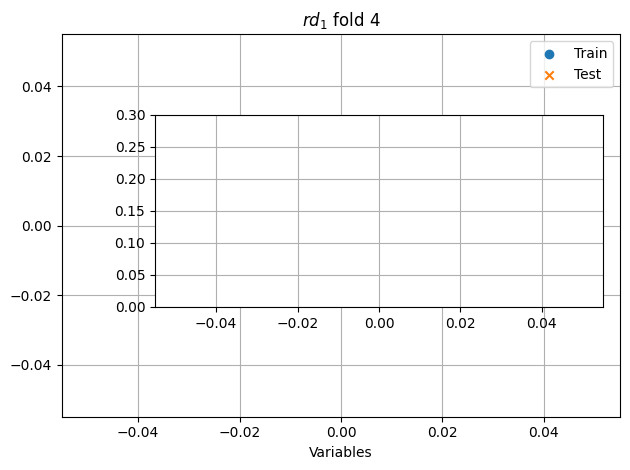

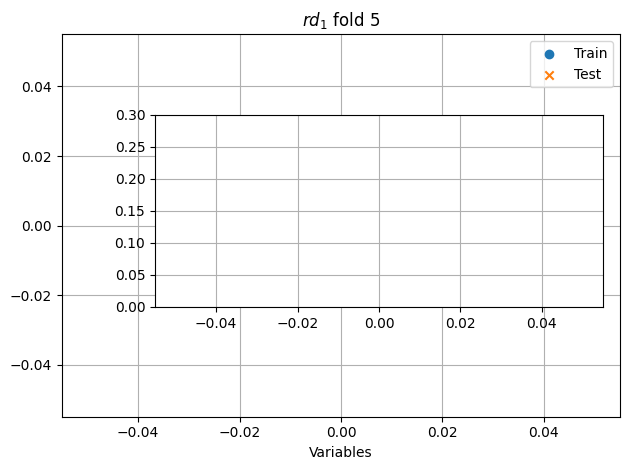

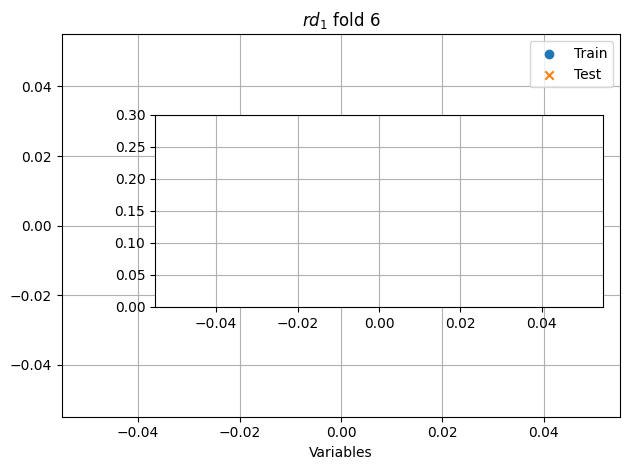

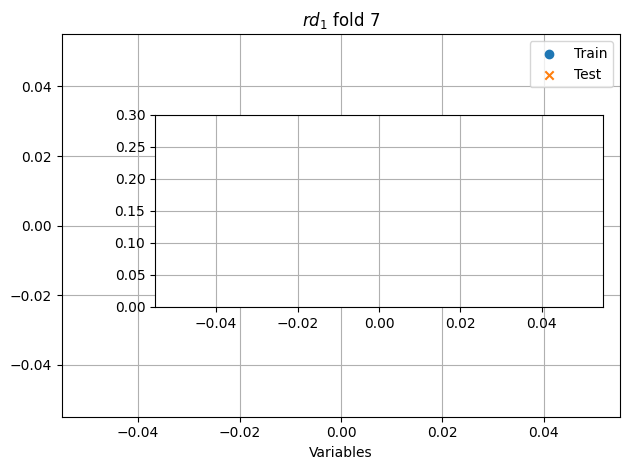

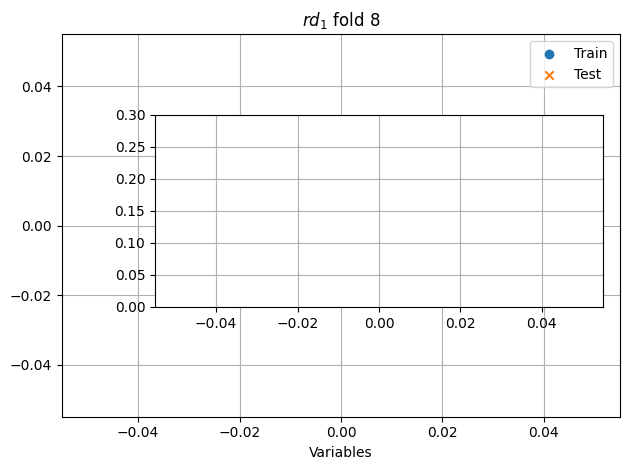

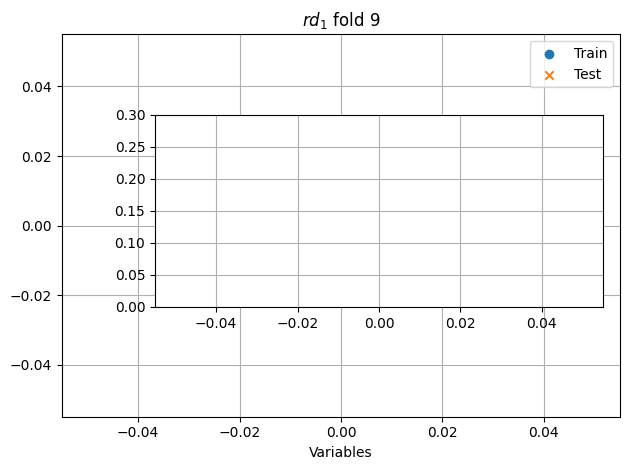

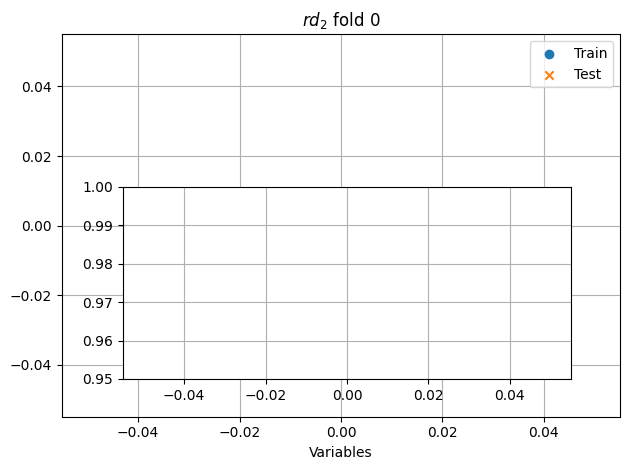

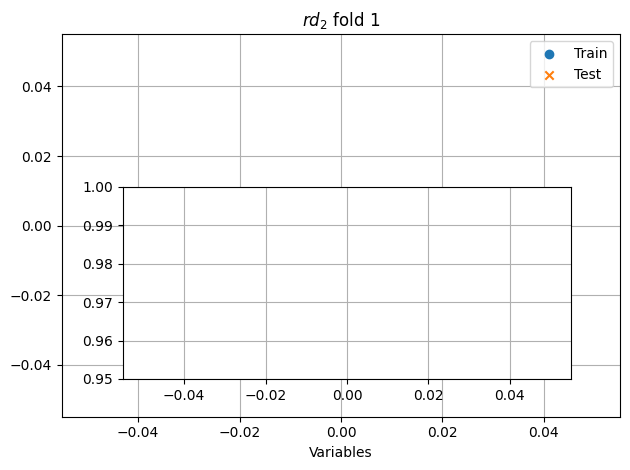

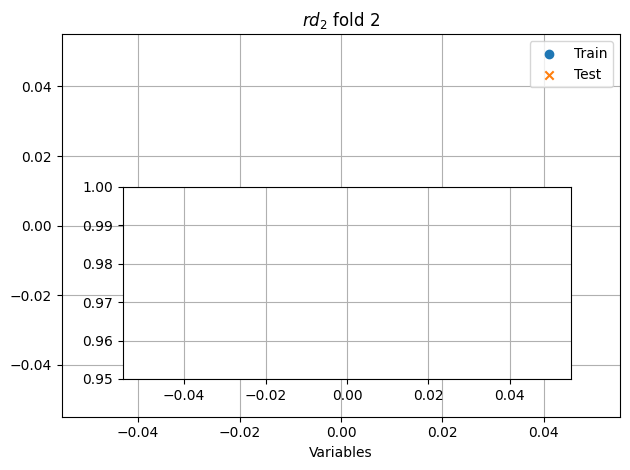

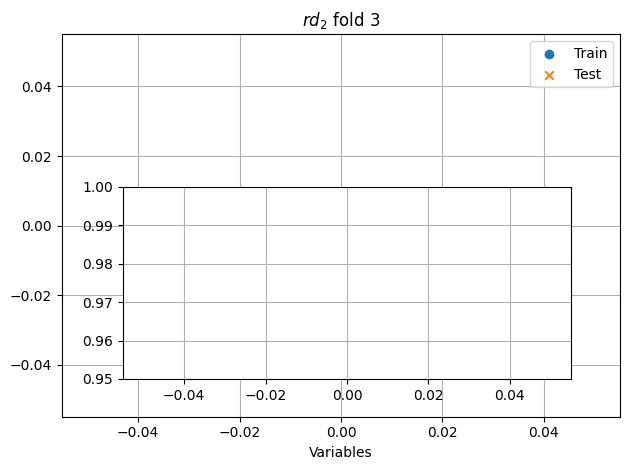

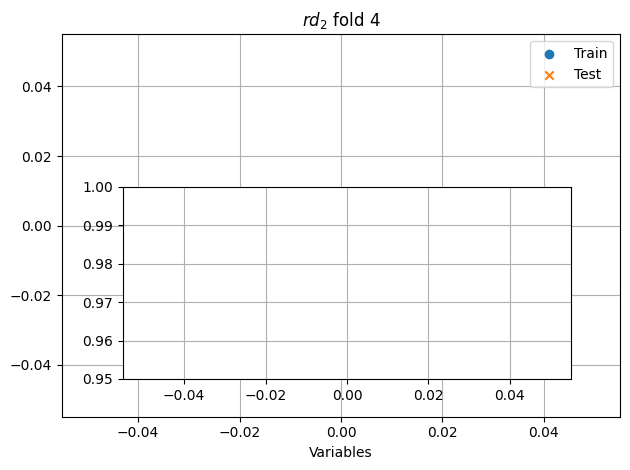

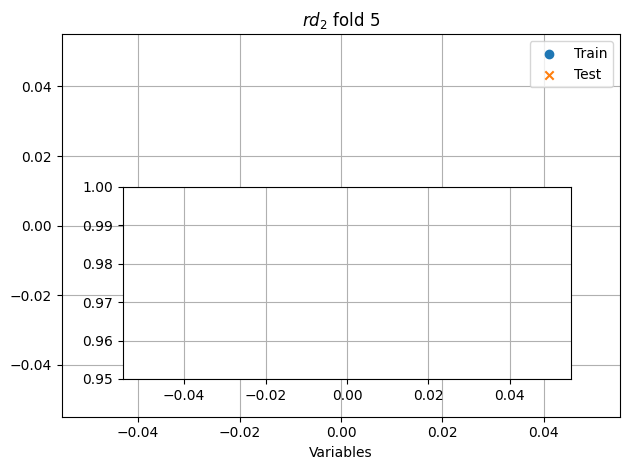

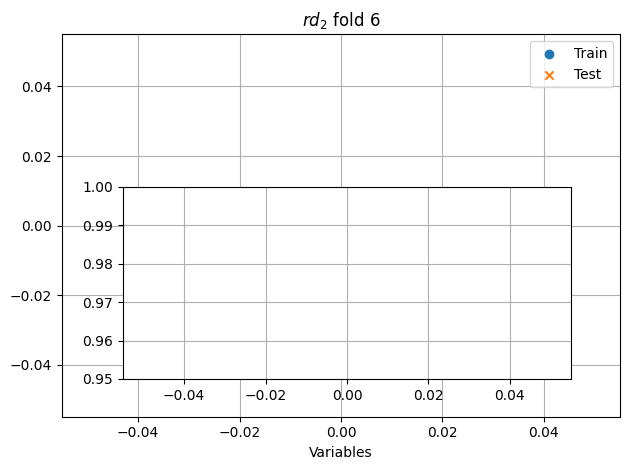

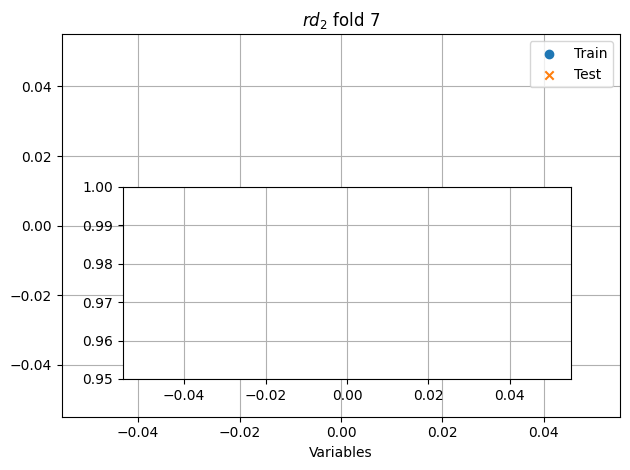

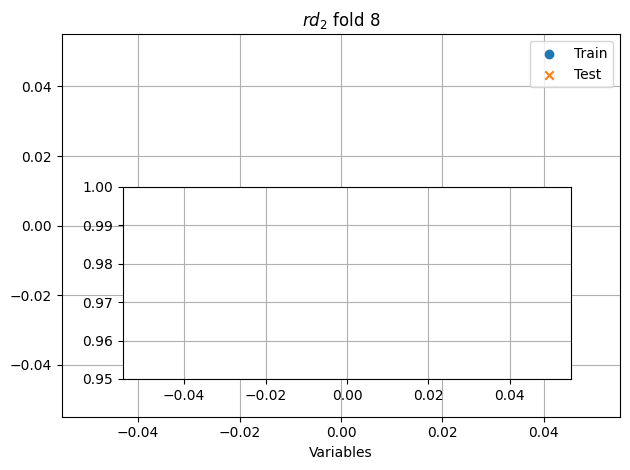

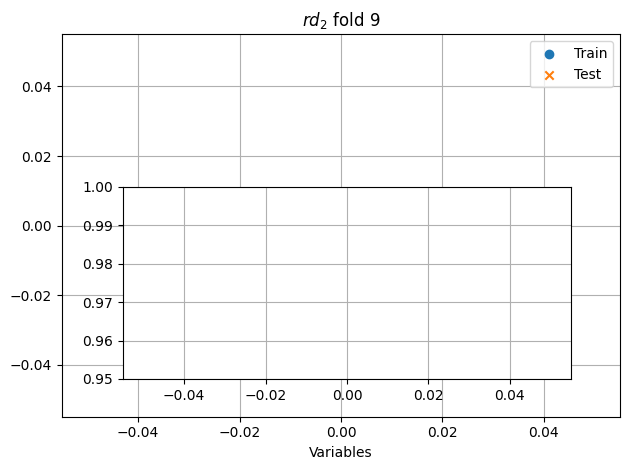

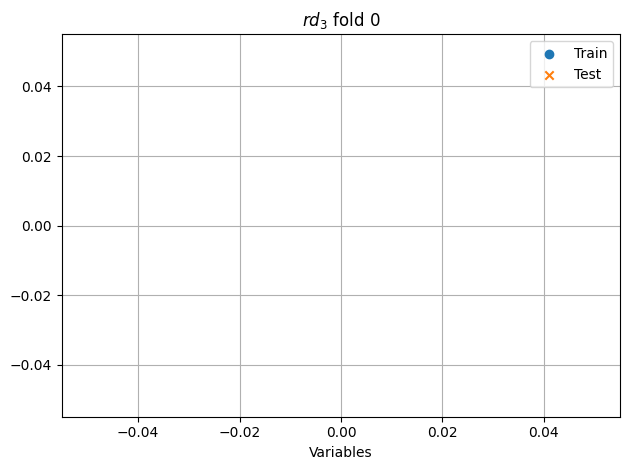

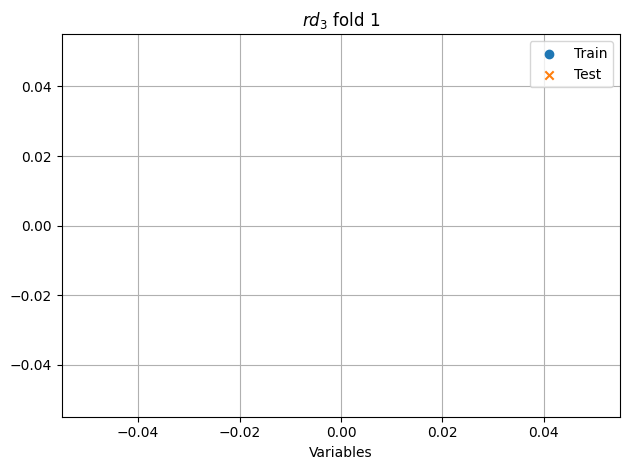

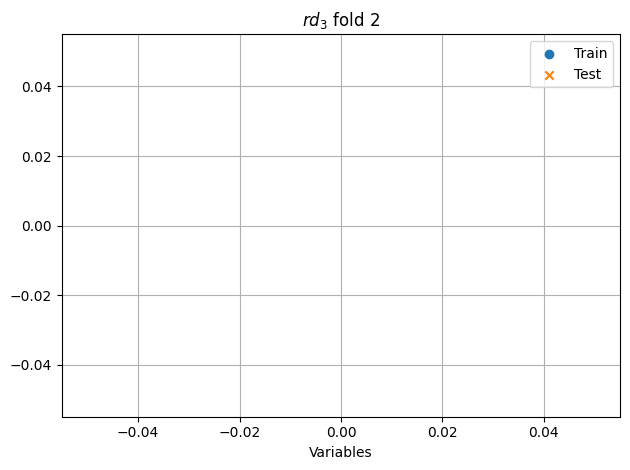

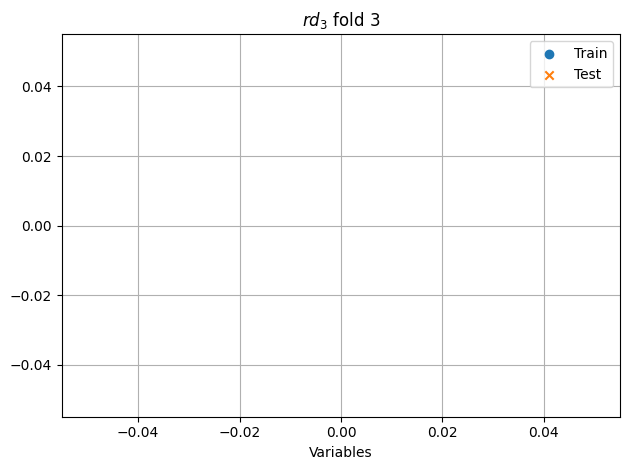

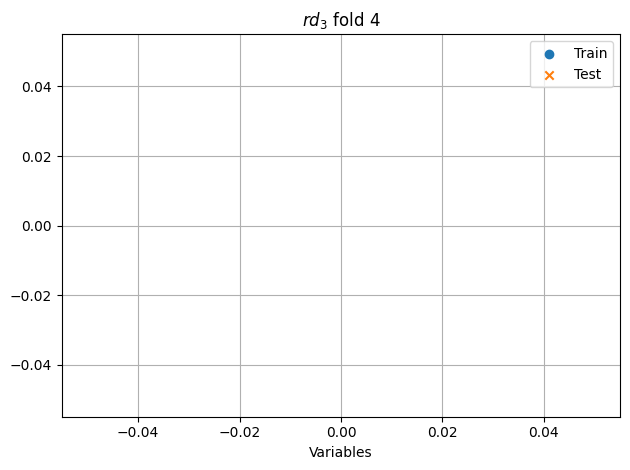

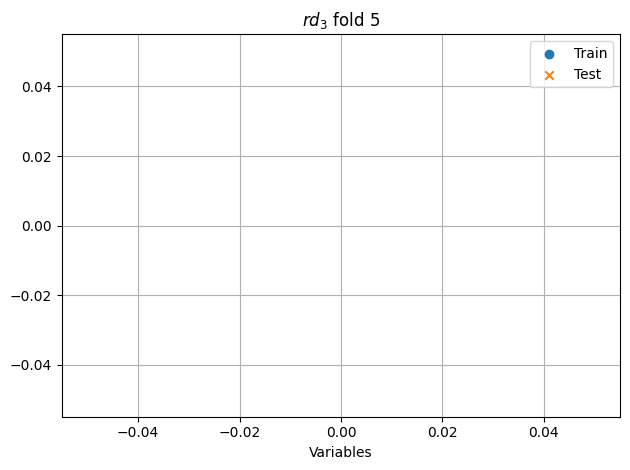

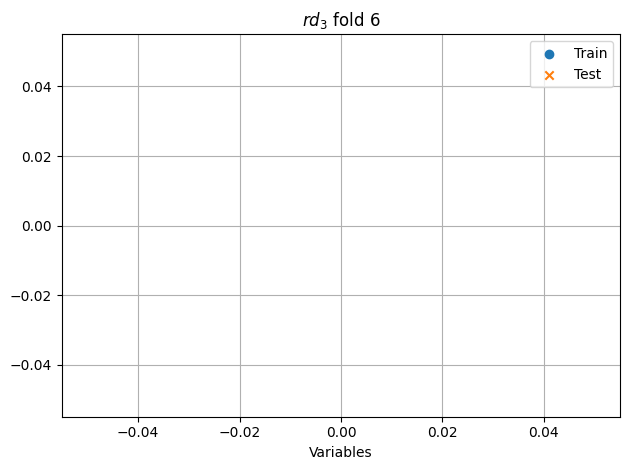

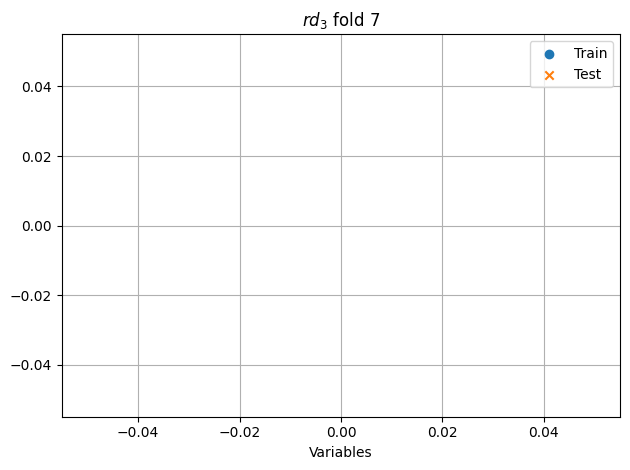

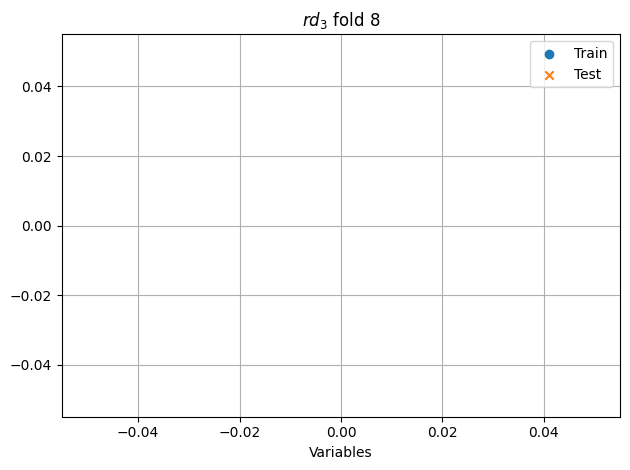

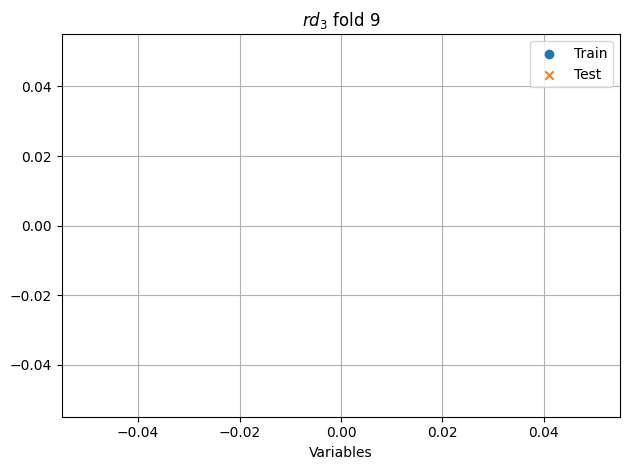

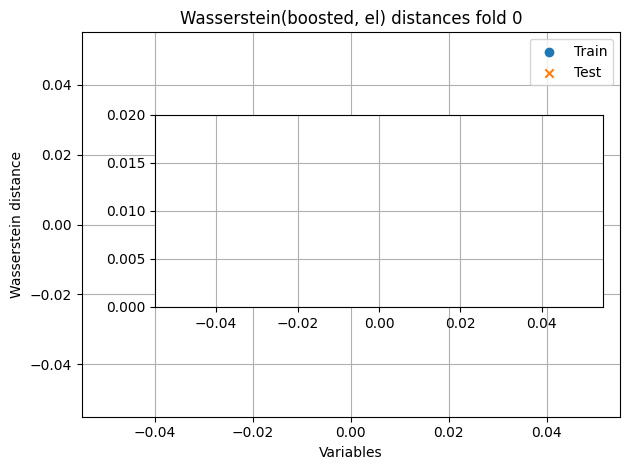

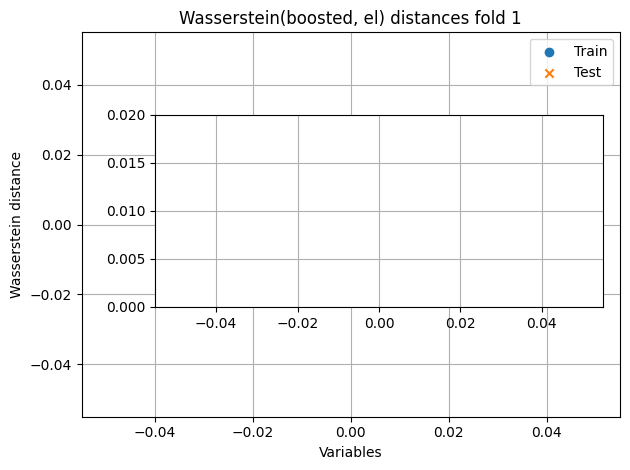

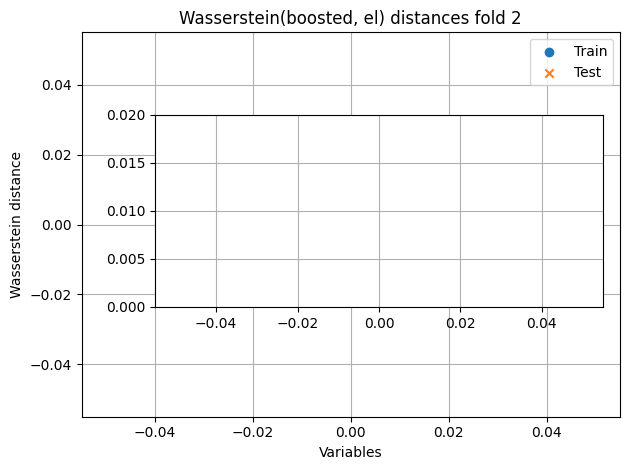

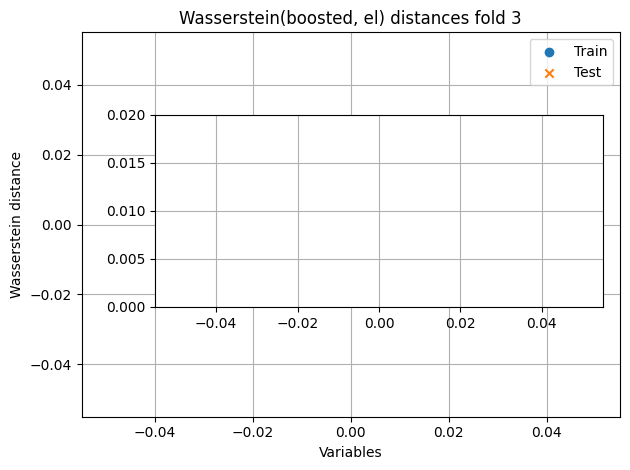

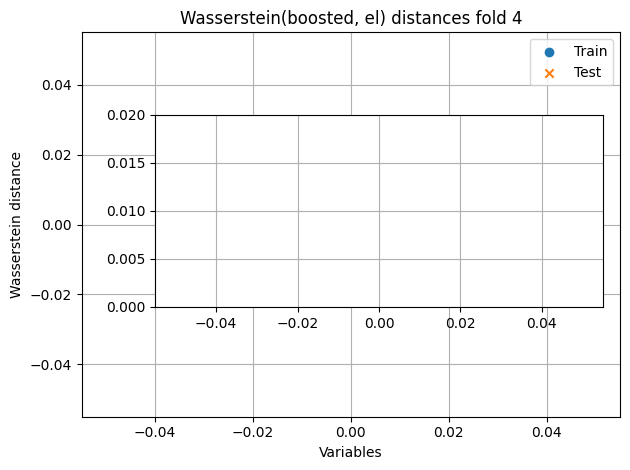

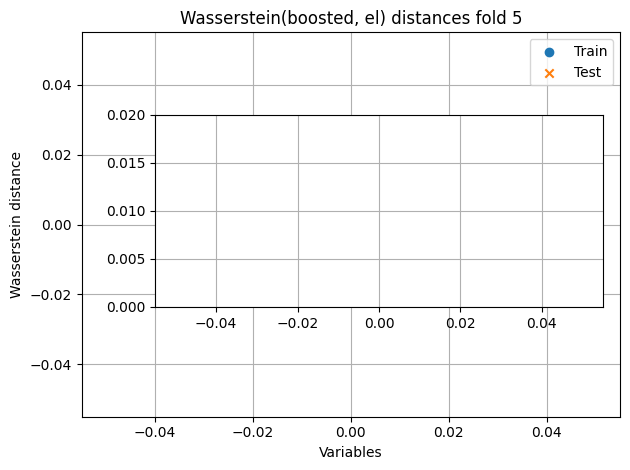

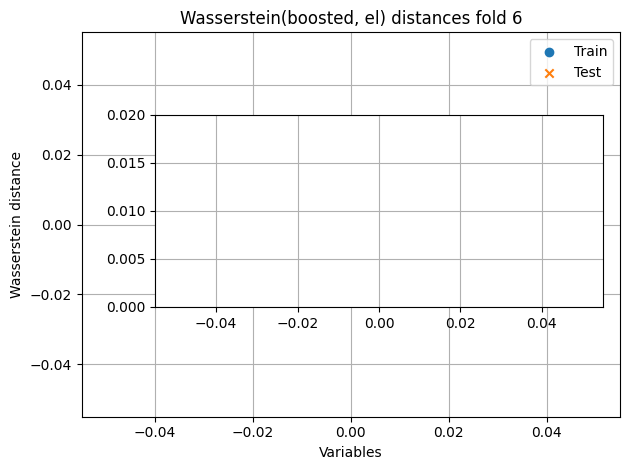

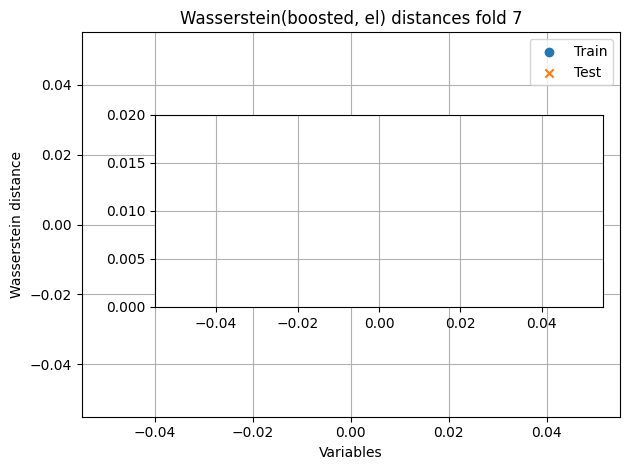

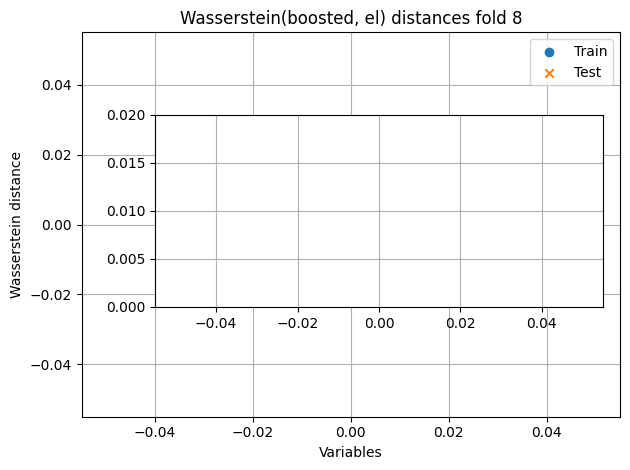

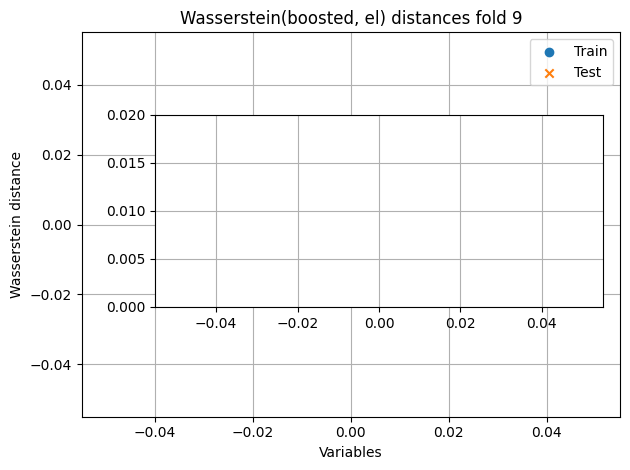

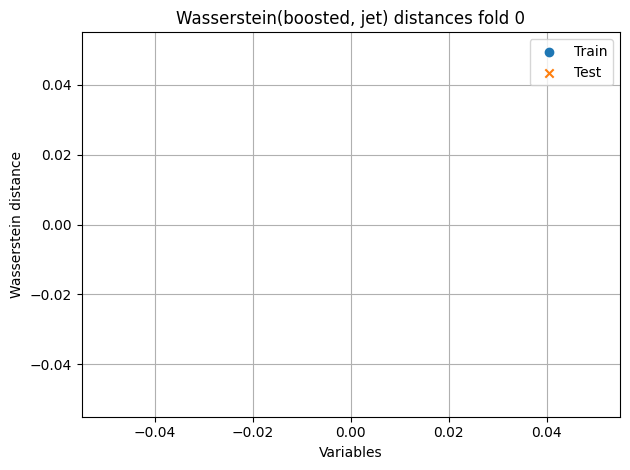

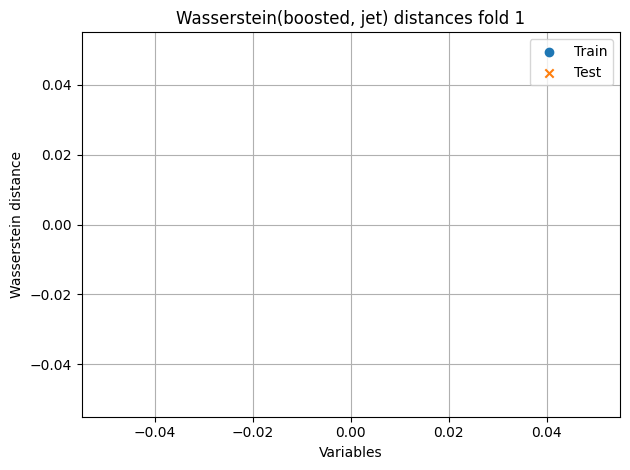

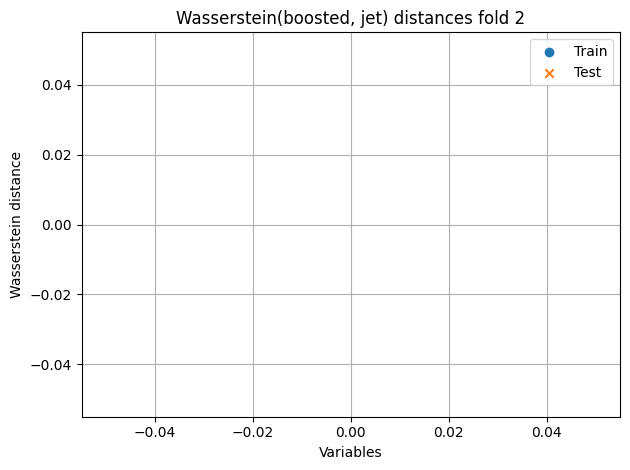

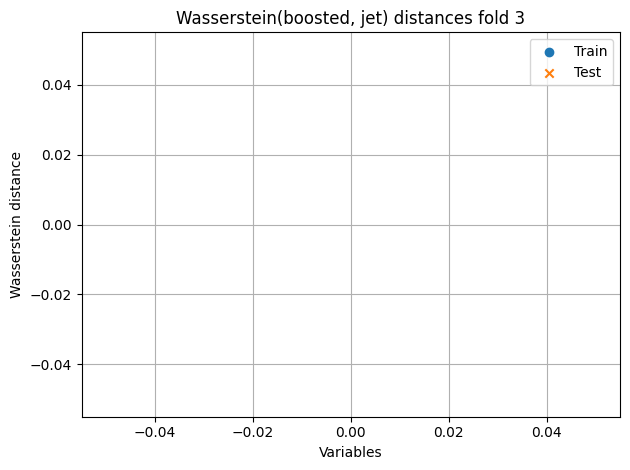

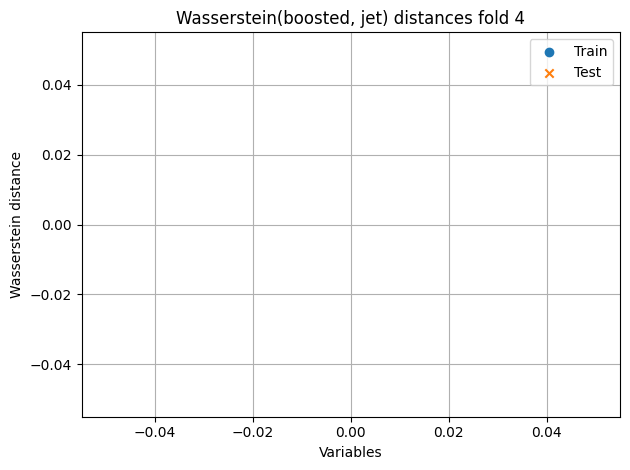

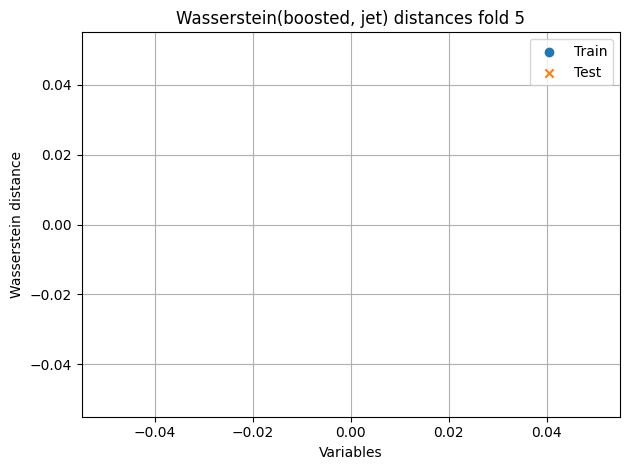

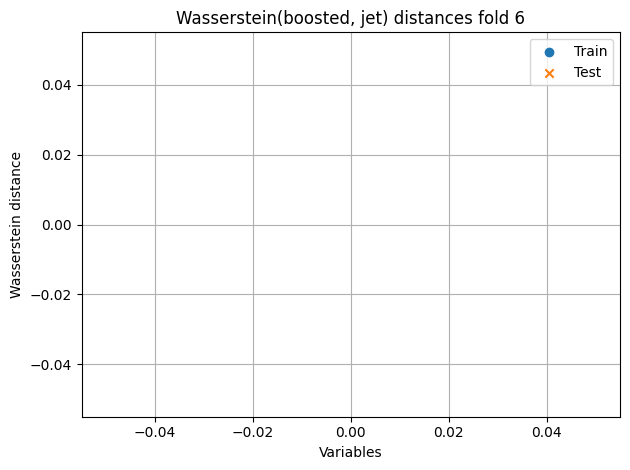

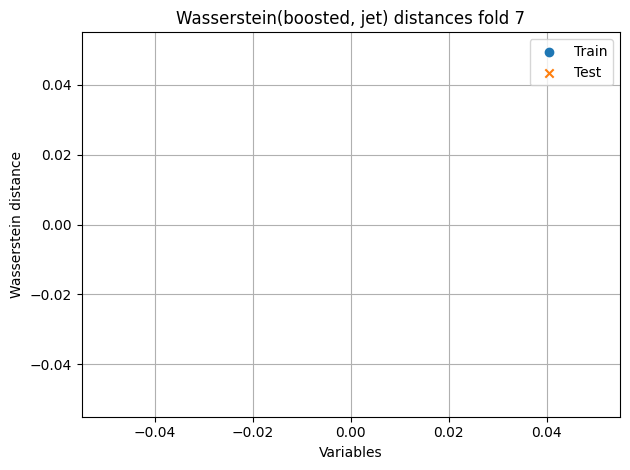

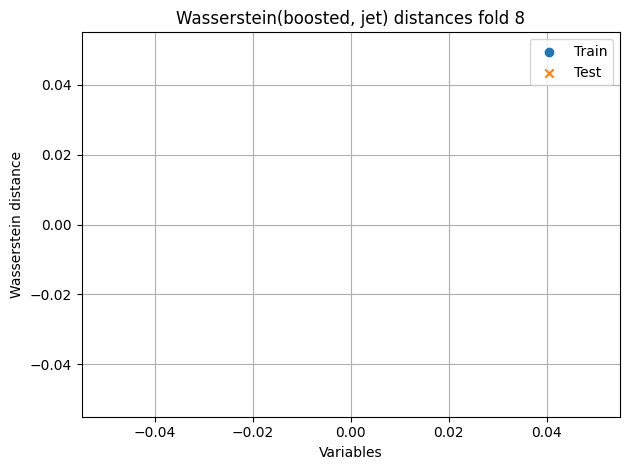

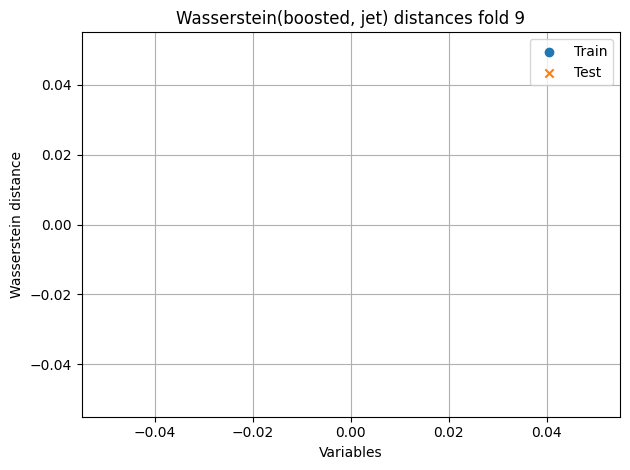

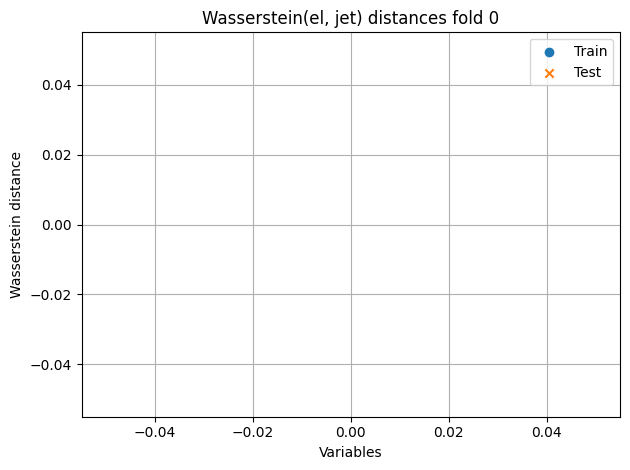

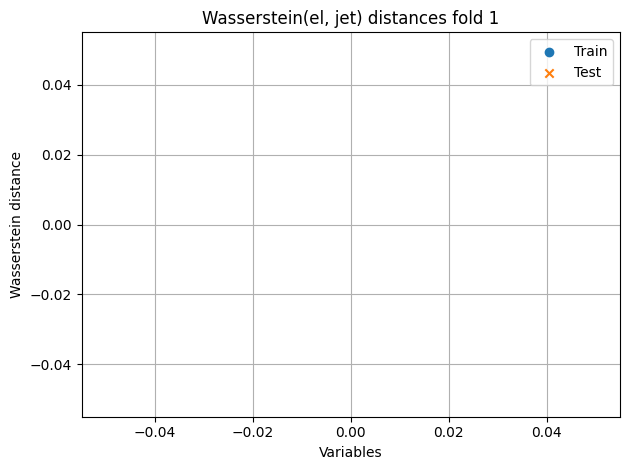

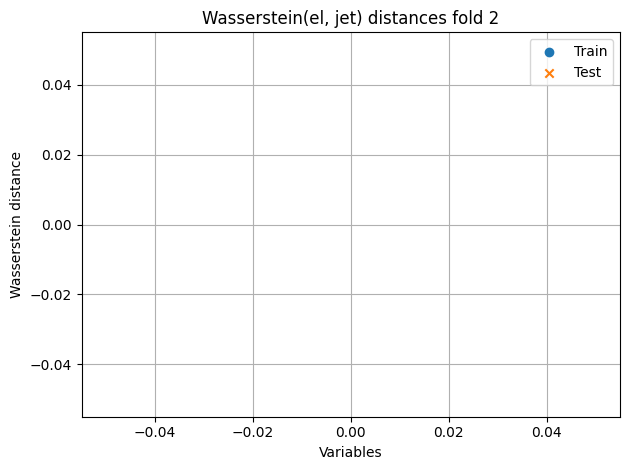

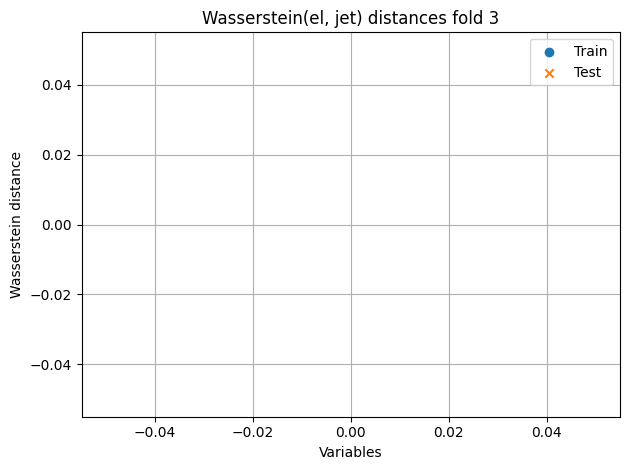

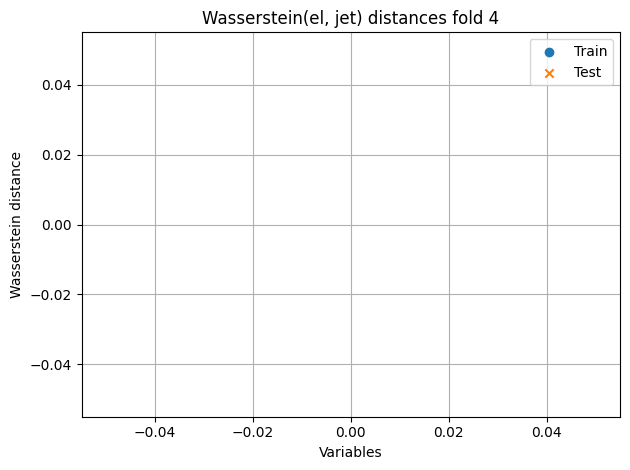

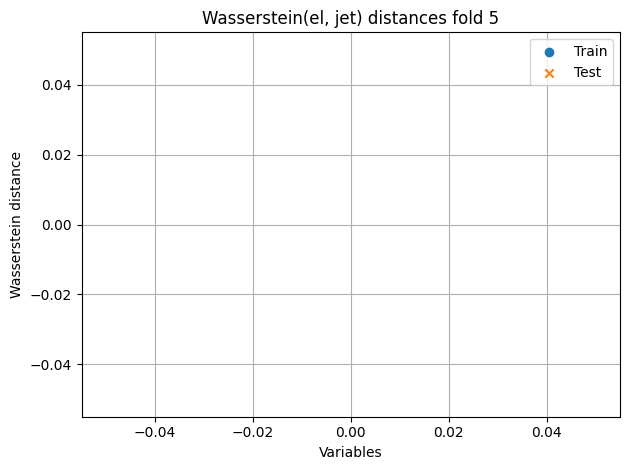

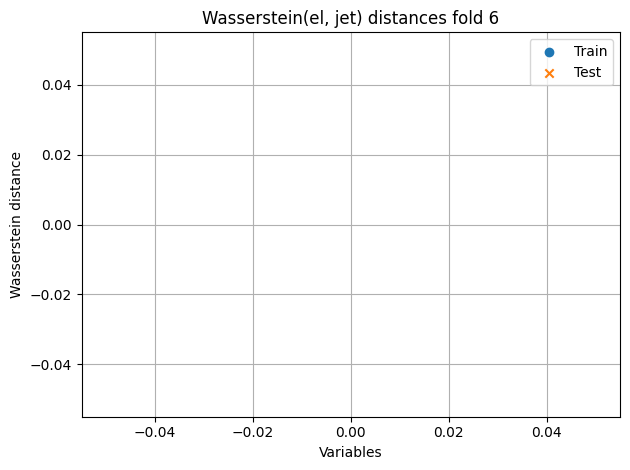

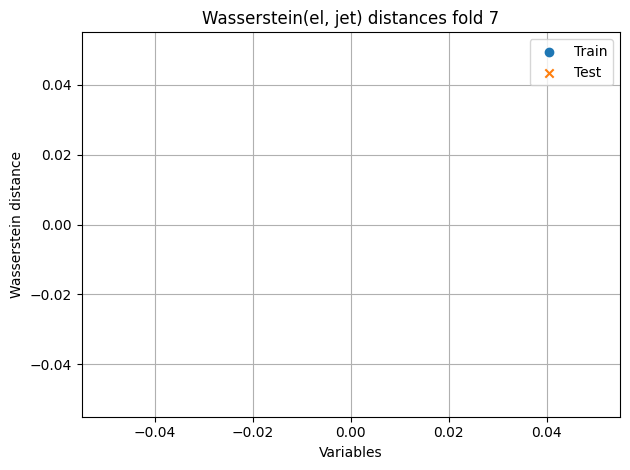

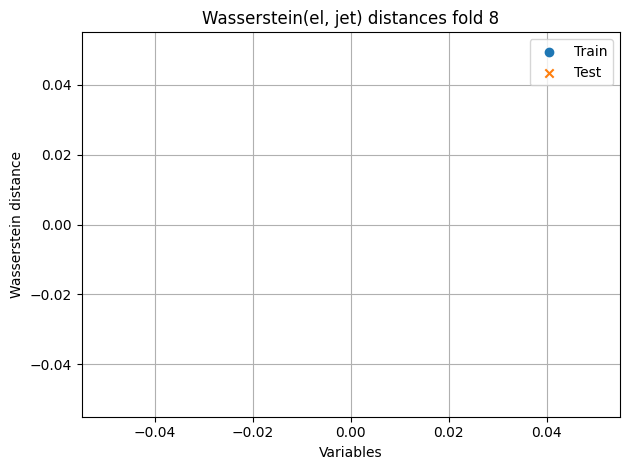

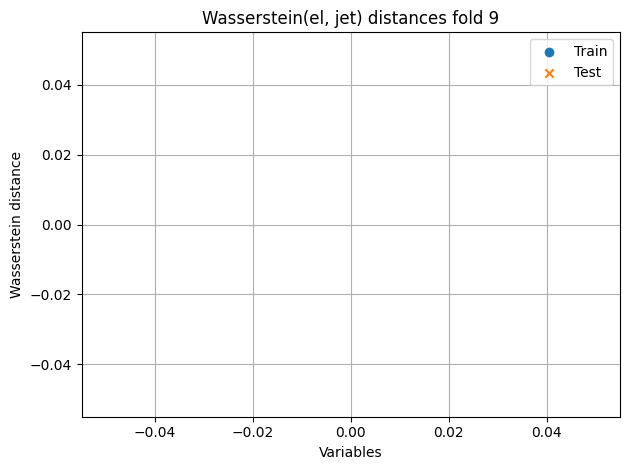

In [15]:
sub_ax_kwargs = defaultdict(lambda: None)
sub_ax_kwargs["boosted_el"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.02))
sub_ax_kwargs["ratio1_extra"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.4))
sub_ax_kwargs["ratio1"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.3))
sub_ax_kwargs["ratio2"] = dict(pos=[0.2, 0.2, 0.7, 0.4], ylim=(0.95,1))
plots = dict()
product_iter = product(metric_labels.keys(),
                       wass_distances["fold_n"].unique())
for metric_name, ifold in product_iter:
    is_distance = not metric_name.startswith("ratio")
    plots[metric_name] = plt.subplots()
    fig, ax = plots[metric_name]
    ax.grid()
    if sub_ax_kwargs[metric_name]:
        sub_ax = fig.add_axes(sub_ax_kwargs[metric_name]["pos"])
        sub_ax.grid()
    for i , dataset_type in enumerate(DATASET_TYPES):
        print(f"Plotting {metric_name} {dataset_type}")
        is_test = dataset_type == "test"
        marker = "x" if is_test else "o"
        color = f"C{i}"
        label = dataset_type.capitalize()
        xlabel = "Variables"
        
        if is_distance:
            title = f"{metric_labels[metric_name]} distances fold {ifold}"
            ylabel = "Wasserstein distance"
        else:
            title = f"{metric_labels[metric_name]} fold {ifold}"
            ylabel = None
        
        is_metric = wass_distances["var"] == metric_name
        is_fold_num = wass_distances["fold_n"] == ifold
        plot_df = wass_distances.loc[is_metric & is_fold_num]
        ax.scatter(plot_df["var"], plot_df[metric_name],
                   marker=marker, color=color, label=label)     
        ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
        
        if sub_ax_kwargs[metric_name]:
            print(f"Plotting {metric_name} sub ax {dataset_type}")
            sub_ax.scatter(plot_df["var"], plot_df[metric_name],
                   marker=marker, color=color, label=label)
            sub_ax.set(ylim=sub_ax_kwargs[metric_name]["ylim"])
    ax.legend()
    fig.tight_layout()
    # filename = 
    # fig.savefig(os.path.join(output_dir, filename))

In [4]:
def kfold_agg_metrics(data: pd.DataFrame, fold_type_col: str, var_col: str, agg_funcs = None) -> pd.DataFrame:
    if agg_funcs is None:
        agg_funcs = ['mean', 'std', "min", "max"]
    described_dataset = data.groupby([var_col, fold_type_col]).agg(agg_funcs)
    cols2melt = described_dataset.columns.to_list()
    described_dataset = described_dataset.reset_index()
    described_dataset = described_dataset.melt(
        id_vars=[(var_col,""), (fold_type_col,"")],
        value_vars=cols2melt,
        var_name=["metric", "agg_metric"]
    )
    described_dataset = described_dataset.rename({
        (fold_type_col,""): fold_type_col,
        (var_col,""): var_col
    }, axis=1)
    described_dataset["metric"] = described_dataset["metric"].astype("category")
    described_dataset["agg_metric"] = described_dataset["agg_metric"].astype("category")
    described_dataset[fold_type_col] = described_dataset[fold_type_col].astype("category")
    described_dataset[var_col] = described_dataset[var_col].astype("category")
    return described_dataset

columns_to_agg = wass_distances.columns[~wass_distances.columns.isin(["fold_n"])]
fold_description = kfold_agg_metrics(wass_distances[columns_to_agg],
                                   fold_type_col="fold_type",
                                   var_col="var")
fold_description

/tmp/ipykernel_2978335/718985570.py:4: FutureWarning: ['description'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  described_dataset = data.groupby([var_col, fold_type_col]).agg(agg_funcs)


,var,fold_type,metric,agg_metric,value
0,el_rhad,test,boosted_el,mean,0.000170
1,el_rhad,train,boosted_el,mean,0.000171
2,el_rhad1,test,boosted_el,mean,0.000234
3,el_rhad1,train,boosted_el,mean,0.000234
4,el_rphi,test,boosted_el,mean,0.010886
...,...,...,...,...,...
427,trig_L2_cl_reta,train,ratio3,max,0.065259
428,trig_L2_cl_weta2,test,ratio3,max,0.055635
429,trig_L2_cl_weta2,train,ratio3,max,0.055442
430,trig_L2_cl_wstot,test,ratio3,max,0.007668


Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_jet train
Plotting boosted_jet test
Plotting el_jet train
Plotting el_jet test


/tmp/ipykernel_2978335/2154789294.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio2 train
Plotting ratio2 sub ax train
Plotting ratio2 test
Plotting ratio2 sub ax test
Plotting ratio3 train
Plotting ratio3 test


/tmp/ipykernel_2978335/2154789294.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_2978335/2154789294.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


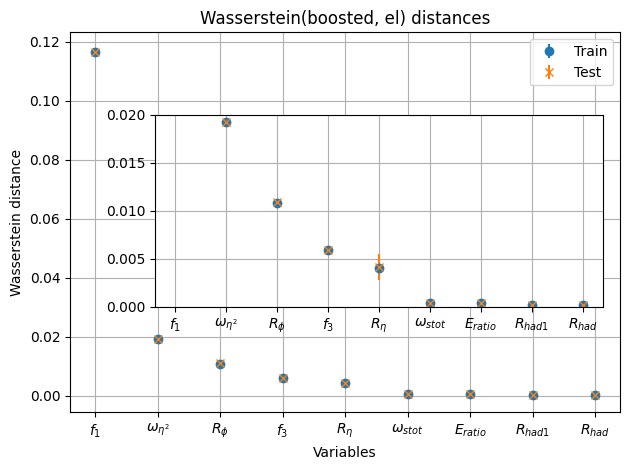

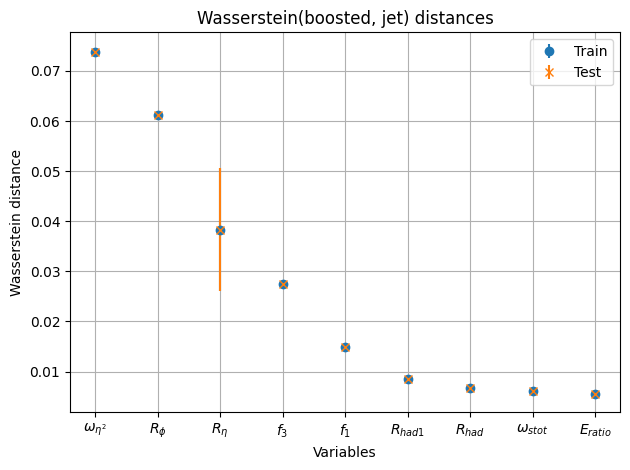

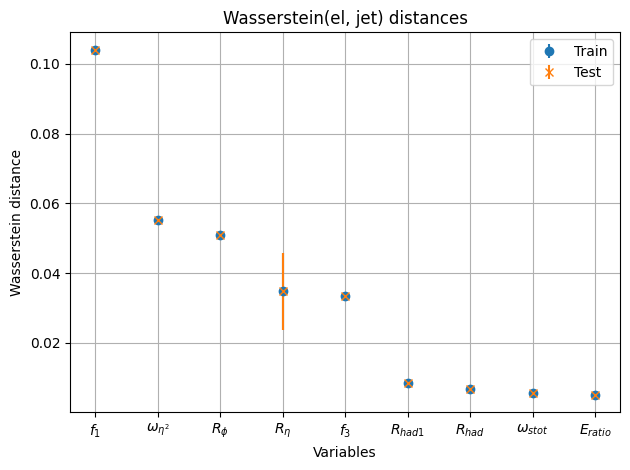

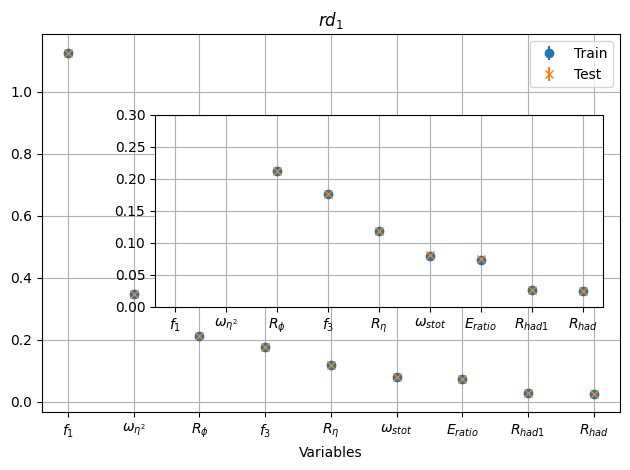

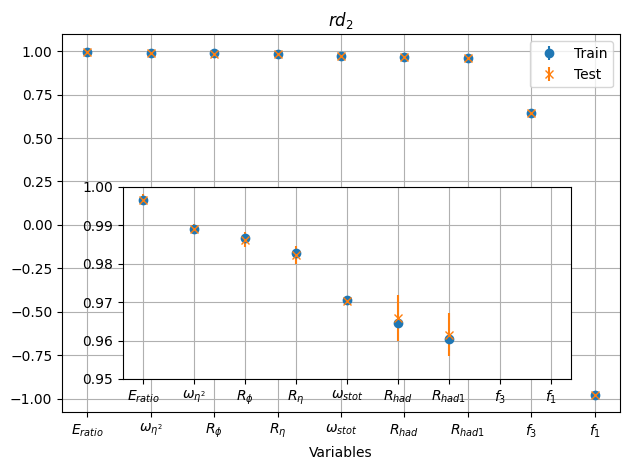

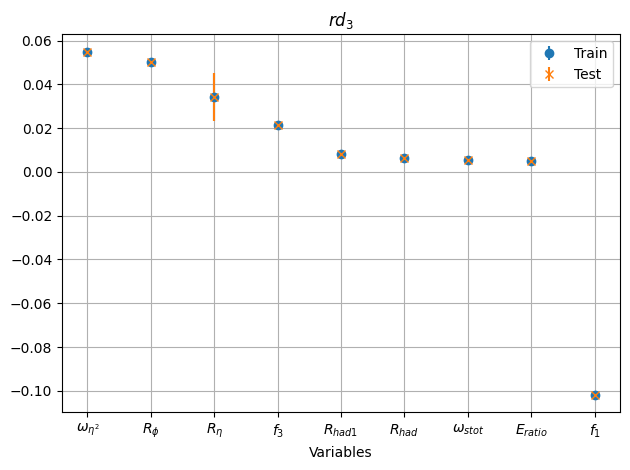

In [6]:
sub_ax_kwargs = defaultdict(lambda: None)
sub_ax_kwargs["boosted_el"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.02))
sub_ax_kwargs["ratio1_extra"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.4))
sub_ax_kwargs["ratio1"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.3))
sub_ax_kwargs["ratio2"] = dict(pos=[0.2, 0.2, 0.7, 0.4], ylim=(0.95,1))
plots = dict()
dataset_type_col="fold_type"
for metric in fold_description["metric"].unique():
    is_distance = not metric.startswith("ratio")
    plots[metric] = plt.subplots()
    fig, ax = plots[metric]
    ax.grid()
    if sub_ax_kwargs[metric]:
        sub_ax = fig.add_axes(sub_ax_kwargs[metric]["pos"])
        sub_ax.grid()
    for i , dataset_type in enumerate(DATASET_TYPES):
        print(f"Plotting {metric} {dataset_type}")
        is_test = dataset_type == "test"
        marker = "x" if is_test else "o"
        color = f"C{i}"
        label = dataset_type.capitalize()
        xlabel = "Variables"
        
        if is_distance:
            title = f"{metric_labels[metric]} distances"
            ylabel = "Wasserstein distance"
        else:
            title = metric_labels[metric]
            ylabel = None
        
        is_test = dataset_type == "test"
        is_type = fold_description[dataset_type_col] == dataset_type
        is_mean = fold_description["agg_metric"] == "mean"
        is_std = fold_description["agg_metric"] == "std"
        valid_sample = is_type
        plot_df = fold_description.loc[valid_sample & (is_mean | is_std)]
        plot_df = plot_df.pivot(index="var",
                                values="value",
                                columns=["metric", "agg_metric"])
        plot_df = plot_df.rename(var_infos["label"], axis=0)
        plot_df = plot_df.sort_values(by=(metric, "mean"), ascending=False)
        ax.errorbar(plot_df.index, plot_df[(metric, "mean")],
                    yerr=plot_df[(metric, "std")],
                    fmt=marker, color=color,
                    label=label)        
        ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
        
        if sub_ax_kwargs[metric]:
            print(f"Plotting {metric} sub ax {dataset_type}")
            sub_ax.errorbar(plot_df.index, plot_df[(metric, "mean")],
                            yerr=plot_df[(metric, "std")],
                            fmt=marker, color=color)
            sub_ax.set(ylim=sub_ax_kwargs[metric]["ylim"])
    ax.legend()
    fig.tight_layout()
    filename = 
    fig.savefig(os.path.join(output_dir, filename))

In [7]:
wass_distance_columns = ["var", 'boosted_el', 'boosted_jet', 'el_jet']
is_train = wass_distances["fold_type"] == "train"
train_data = (wass_distances.loc[is_train, wass_distance_columns]
                  .set_index("var")
                  .rename(var_infos["label"], axis=0)
                  .rename(metric_labels, axis=1))
train_data.index.name = 'Shower Shape Variable'
latex_repr = confidence_region_df_as_latex(train_data,
                                           groupby='Shower Shape Variable',
                                           sort_values=dict(by=metric_labels['boosted_el'], ascending=True))
print(latex_repr)

\begin{tabular}{||c|c|c|c|c||}
 & Shower Shape Variable & Wasserstein(boosted, el) & Wasserstein(boosted, jet) & Wasserstein(el, jet) \\
0 & $R_{had}$ & $0.00017 \pm 0.00002$ & $0.0066 \pm 0.0009$ & $0.0067 \pm 0.0009$ \\
\cline{1-5}
1 & $R_{had1}$ & $0.00023 \pm 0.00001$ & $0.0085 \pm 0.0004$ & $0.0086 \pm 0.0004$ \\
\cline{1-5}
2 & $E_{ratio}$ & $0.000383 \pm 0.000001$ & $0.005540 \pm 0.000003$ & $0.005175 \pm 0.000002$ \\
\cline{1-5}
3 & $\omega_{stot}$ & $0.00046 \pm 0.00006$ & $0.0061 \pm 0.0008$ & $0.0058 \pm 0.0007$ \\
\cline{1-5}
4 & $R_{\eta}$ & $0.004 \pm 0.001$ & $0.04 \pm 0.01$ & $0.03 \pm 0.01$ \\
\cline{1-5}
5 & $f_3$ & $0.00593 \pm 0.00007$ & $0.0275 \pm 0.0004$ & $0.0334 \pm 0.0004$ \\
\cline{1-5}
6 & $R_{\phi}$ & $0.010848 \pm 0.000008$ & $0.06123 \pm 0.00001$ & $0.051055 \pm 0.000006$ \\
\cline{1-5}
7 & $\omega_{\eta^2}$ & $0.0192 \pm 0.0001$ & $0.0738 \pm 0.0004$ & $0.0552 \pm 0.0003$ \\
\cline{1-5}
8 & $f_1$ & $0.1167 \pm 0.0001$ & $0.01488 \pm 0.00007$ & $0.1039 \p

In [9]:
wass_distance_columns = ["var", 'boosted_el', 'boosted_jet', 'el_jet']
is_train = wass_distances["fold_type"] == "test"
train_data = (wass_distances.loc[is_train, wass_distance_columns]
                  .set_index("var")
                  .rename(var_infos["label"], axis=0)
                  .rename(metric_labels, axis=1))
train_data.index.name = 'Shower Shape Variable'
latex_repr = confidence_region_df_as_latex(train_data,
                                           groupby='Shower Shape Variable',
                                           sort_values=dict(by=metric_labels['boosted_el'], ascending=True))
print(latex_repr)

\begin{tabular}{||c|c|c|c|c||}
 & Shower Shape Variable & Wasserstein(boosted, el) & Wasserstein(boosted, jet) & Wasserstein(el, jet) \\
0 & $R_{had}$ & $0.00017 \pm 0.00003$ & $0.0066 \pm 0.0009$ & $0.0067 \pm 0.0010$ \\
\cline{1-5}
1 & $R_{had1}$ & $0.00023 \pm 0.00003$ & $0.0085 \pm 0.0004$ & $0.0086 \pm 0.0004$ \\
\cline{1-5}
2 & $E_{ratio}$ & $0.000388 \pm 0.000007$ & $0.005546 \pm 0.000007$ & $0.005175 \pm 0.000005$ \\
\cline{1-5}
3 & $\omega_{stot}$ & $0.00047 \pm 0.00006$ & $0.0061 \pm 0.0008$ & $0.0058 \pm 0.0007$ \\
\cline{1-5}
4 & $R_{\eta}$ & $0.004 \pm 0.001$ & $0.04 \pm 0.01$ & $0.03 \pm 0.01$ \\
\cline{1-5}
5 & $f_3$ & $0.0059 \pm 0.0002$ & $0.0275 \pm 0.0003$ & $0.0334 \pm 0.0004$ \\
\cline{1-5}
6 & $R_{\phi}$ & $0.01089 \pm 0.00008$ & $0.0612 \pm 0.0001$ & $0.05106 \pm 0.00005$ \\
\cline{1-5}
7 & $\omega_{\eta^2}$ & $0.0192 \pm 0.0002$ & $0.0738 \pm 0.0004$ & $0.0552 \pm 0.0003$ \\
\cline{1-5}
8 & $f_1$ & $0.1167 \pm 0.0007$ & $0.0149 \pm 0.0006$ & $0.1039 \pm 0.0002$ 

In [23]:
def get_order(df: pd.DataFrame, sort_col: str) -> pd.Series:
    ascending = sort_col.startswith('ratio1')
    df = df.sort_values(sort_col, ascending=ascending)
    ordered_ss = df["var"].values
    values = df[sort_col].values
    row = pd.Series(
        [ordered_ss, values],
        index=['order', 'values']
    )
    return row
orders = {
    name: (wass_distances.reset_index()
                         .groupby(["fold_type", "fold_n"])
                         .apply(get_order, sort_col=name)) # type: ignore
    for name in ratios.keys()
}
orders['ratio1']

order  \
fold_type fold_n                                                      
test      0       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          1       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          2       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          3       ['el_rhad1', 'el_rhad', 'trig_L2_cl_eratio', '...   
          4       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          5       ['el_rhad1', 'el_rhad', 'trig_L2_cl_eratio', '...   
          6       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          7       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          8       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          9       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
train     0       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          1       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          2       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          3       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          4       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          5       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          6       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          7       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          8       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   
          9       ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', '...   

                                                             values  
fold_type fold_n                                                     
test      0       [0.021602439953994926, 0.02428939251402432, 0....  
          1       [0.02521576121039809, 0.028475825458976773, 0....  
          2       [0.026571005423131712, 0.028329553966390777, 0...  
          3       [0.025695986024973024, 0.02853933507467383, 0....  
          4       [0.023647259822002685, 0.026349600615674672, 0...  
          5       [0.03031619017688846, 0.030511069807849917, 0....  
          6       [0.020001366388914303, 0.023049915595301774, 0...  
          7       [0.021527105326771257, 0.023610427331777272, 0...  
          8       [0.0250125622785878, 0.02779409389238312, 0.07...  
          9       [0.03251231161743455, 0.033829205830212344, 0....  
train     0       [0.025929686664289568, 0.027461283282796064, 0...  
          1       [0.02552251955961858, 0.026995612836808472, 0....  
          2       [0.02537288818257583, 0.027010931971178202, 0....  
          3       [0.025153449954010424, 0.027305066823871446, 0...  
          4       [0.02569626721294092, 0.027230795156184498, 0....  
          5       [0.02493387150140772, 0.026790173662309347, 0....  
          6       [0.026103202481035915, 0.027603454766091547, 0...  
          7       [0.025933828415606427, 0.027539141344293736, 0...  
          8       [0.025545858593145707, 0.027074514246343422, 0...  
          9       [0.02471517183182129, 0.02640447376436706, 0.0...

In [27]:
def get_order_differences(df: pd.DataFrame, n_folds: int):
    differences = list()
    for ifold in range(n_folds):
        train_fold_order = df.loc[("train", ifold), 'order']
        test_fold_order = df.loc[("test", ifold), 'order']
        is_different = (train_fold_order !=
                        test_fold_order).any()   # type: ignore
        if is_different:
            differences.append(f'fold_{ifold}')
    return differences

order_differences = {
    ratio_name: get_order_differences(ratio_order, n_folds)
    for ratio_name, ratio_order in orders.items()
}
order_differences

{'ratio1': ['fold_3', 'fold_5'],
 'ratio2': ['fold_0', 'fold_5', 'fold_6', 'fold_7', 'fold_8'],
 'ratio3': []}

In [38]:
def side_by_side_vis(orders, ratio, fold_n):
    df = orders[ratio]
    for fold_type in ["train", "test"]:
        for col in ['order', 'values']:
            try:
                print(f'{fold_type}: {df.loc[(fold_type, fold_n), col].to_list()}')
            except Exception:
                print(f'{fold_type}: {df.loc[(fold_type, fold_n), col]}')

side_by_side_vis(orders, 'ratio1', 3)

train: ['el_rhad', 'el_rhad1', 'trig_L2_cl_eratio', 'trig_L2_cl_wstot', 'trig_L2_cl_reta', 'trig_L2_cl_f3', 'el_rphi', 'trig_L2_cl_weta2', 'trig_L2_cl_f1']
train: [0.02515345 0.02730507 0.07376395 0.08034261 0.1177823  0.17773073
 0.21256036 0.34825292 1.12385391]
test: ['el_rhad1', 'el_rhad', 'trig_L2_cl_eratio', 'trig_L2_cl_wstot', 'trig_L2_cl_reta', 'trig_L2_cl_f3', 'el_rphi', 'trig_L2_cl_weta2', 'trig_L2_cl_f1']
test: [0.02569599 0.02853934 0.07645032 0.08000313 0.12037647 0.17306702
 0.21239692 0.35058687 1.11451136]
